# ACO Projekt – Gráfos optimalizálás (TSM stílus)

Ebben a notebookban egy teljes ACO-implementációt kell készítened
egy gráfos feladatra (pl. legrövidebb út vagy körút keresése).

Én ebben az esetben a legrövidebb út keresését választottam.

## 1. Gráf definiálása / betöltése

In [23]:
import random
import networkx as nx

def generate_random_connected_graph(num_nodes, max_weight):
    G = nx.Graph()
    nodes = list(range(num_nodes))
    G.add_nodes_from(nodes)

    for i in range(num_nodes - 1):
        weight = round(random.uniform(1.0, max_weight), 1)
        G.add_edge(nodes[i], nodes[i+1], weight=weight)

    num_additional_edges = random.randint(num_nodes, num_nodes * 3) # More edges
    edges_added = 0
    while edges_added < num_additional_edges:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and not G.has_edge(u, v):
            weight = round(random.uniform(1.0, max_weight), 1)
            G.add_edge(u, v, weight=weight)
            edges_added += 1

    adj_list_graph = {i: {} for i in range(num_nodes)}
    for u, v, data in G.edges(data=True):
        adj_list_graph[u][v] = data['weight']
        adj_list_graph[v][u] = data['weight']

    return adj_list_graph

num_nodes = 10
max_weight = 15.0
graph = generate_random_connected_graph(num_nodes=num_nodes, max_weight=max_weight)

print(f"Új gráf létrehozva {num_nodes} csomóponttal.")
len(graph)


Új gráf létrehozva 10 csomóponttal.


10

## 2. Feromon és heurisztika inicializálása

In [14]:
def init_pheromones(graph, tau0=0.1):
    tau = {}
    for i in graph:
        tau[i] = {}
        for j in graph[i]:
            tau[i][j] = tau0
    return tau

def init_heuristic(graph):
    eta = {}
    for i in graph:
        eta[i] = {}
        for j, dist in graph[i].items():
            eta[i][j] = 1.0 / dist
    return eta

tau = init_pheromones(graph)
eta = init_heuristic(graph)
print("Feromon és heurisztika újrainicializálva az új gráfhoz.")


Feromon és heurisztika újrainicializálva az új gráfhoz.


## 3. Lépési valószínűségek és csomópontválasztás

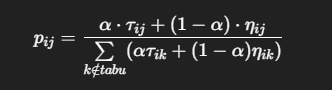

In [15]:
import random

def transition_probabilities(i, tabu, tau, eta, graph, alpha=0.5):
    """
    i: aktuális csomópont
    tabu: már bejárt csúcsok halmaza
    tau: feromon mátrix (tau[i][j])
    eta: heurisztika mátrix (eta[i][j])
    graph: szomszédsági lista (távolságok)
    alpha: súlyozás (0 = csak heurisztika, 1 = csak feromon)
    """
    numerators = {}

    for j in graph[i]:
        if j in tabu:
            continue

        numerators[j] = alpha * tau[i][j] + (1 - alpha) * eta[i][j]

    denom = sum(numerators.values())

    if denom == 0:
        return {j: 0 for j in numerators}

    probs = {j: numerators[j] / denom for j in numerators}
    return probs

def choose_next_node(i, tabu, tau, eta, graph, alpha=0.5):
    probs = transition_probabilities(i, tabu, tau, eta, graph, alpha)

    nodes = list(probs.keys())
    weights = list(probs.values())

    next_node = random.choices(nodes, weights=weights, k=1)[0]
    return next_node

## 4. Hangya megoldásának felépítése

In [16]:
# TODO: egy hangya útvonala
def build_ant_solution(start, goal, graph, tau, eta, alpha=0.5):
    """
    start: kezdő csúcs
    goal: cél csúcs
    graph: szomszédsági lista
    tau: feromon mátrix
    eta: heurisztika mátrix
    alpha: súly a feromon és heurisztika között

    Visszaad: (útvonal_lista, hossz)
    """
    tabu = {start}
    path = [start]
    current = start

    while current != goal:
        if all(n in tabu for n in graph[current]):
            return None, float("inf")

        next_node = choose_next_node(current, tabu, tau, eta, graph, alpha)

        path.append(next_node)
        tabu.add(next_node)
        current = next_node

    length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        length += graph[u][v]

    return path, length

## 5. Útvonal költsége

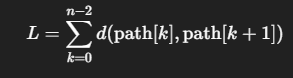

In [17]:
def path_cost(path, graph):
    cost = 0.0
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        cost += graph[u][v]
    return cost

## 6. Feromonfrissítés (párolgással)

In [18]:
def update_pheromones(tau, ant_paths, graph, rho=0.1, Q=1.0):
    #Párolgás
    for i in tau:
        for j in tau[i]:
            tau[i][j] *= (1 - rho)

    #Feromon lerakás
    for path, cost in ant_paths:
        if path is None:
            continue

        deposit = Q / cost

        for k in range(len(path) - 1):
            u = path[k]
            v = path[k + 1]

            tau[u][v] += deposit
            tau[v][u] += deposit

    return tau

## 7. ACO fő ciklus

In [24]:
import matplotlib.pyplot as plt

def run_aco(graph, n_ants=10, n_iters=50, alpha=0.5, rho=0.1, tau0=0.1, start=None, goal=None):
    """
    graph  : szomszédsági lista
    n_ants : hangyák száma
    n_iters: iterációk száma
    alpha  : feromon/heurisztika súly
    rho    : párolgási ráta
    tau0   : kezdeti feromon érték
    start  : kezdő csúcs
    goal   : cél csúcs

    Visszaad:
        best_path   : eddig talált legjobb útvonal
        best_cost   : ennek költsége
        history     : lista minden iteráció legjobb költségéről
    """

    tau = init_pheromones(graph, tau0)
    eta = init_heuristic(graph)

    history = []
    best_path = None
    best_cost = float("inf")

    print(f"=== ACO indul: {n_iters} iter, {n_ants} hangya, start={start}, goal={goal} ===")

    for it in range(n_iters):
        ant_paths = []

        for _ in range(n_ants):
            path, cost = build_ant_solution(start, goal, graph, tau, eta, alpha)
            ant_paths.append((path, cost))

            if cost < best_cost:
                best_cost = cost
                best_path = path

        update_pheromones(tau, ant_paths, graph, rho=rho, Q=1.0)

        history.append(best_cost)
        print(f"Iteráció {it+1:2d}/{n_iters} – Legjobb eddig: {best_cost:.2f}")

    print("\n=== ACO kész ===")
    print("Legjobb talált útvonal:", best_path)
    print("Legjobb út költsége:", best_cost)

    return best_path, best_cost, history

num_nodes_current = len(graph)
start_node = 0 # Beállítható akár randomizálva is                     |=> ebben az esetben szükséges ellenőrizni hogy nem egyforma a ket random szám
goal_node = num_nodes_current - 1 # Beállítható akár randomizálva is  |


print(f"ACO futtatása új gráfon, kezdő {start_node} és cél {goal_node} csomópontokkal.")

best_path, best_cost, history = run_aco(graph, n_ants=50, n_iters=200, alpha=0.5, rho=0.1, tau0=0.1, start=start_node, goal=goal_node)


ACO futtatása új gráfon, kezdő 0 és cél 9 csomópontokkal.
=== ACO indul: 200 iter, 50 hangya, start=0, goal=9 ===
Iteráció  1/200 – Legjobb eddig: 6.20
Iteráció  2/200 – Legjobb eddig: 6.20
Iteráció  3/200 – Legjobb eddig: 6.20
Iteráció  4/200 – Legjobb eddig: 6.20
Iteráció  5/200 – Legjobb eddig: 6.20
Iteráció  6/200 – Legjobb eddig: 6.20
Iteráció  7/200 – Legjobb eddig: 6.20
Iteráció  8/200 – Legjobb eddig: 6.20
Iteráció  9/200 – Legjobb eddig: 6.20
Iteráció 10/200 – Legjobb eddig: 6.20
Iteráció 11/200 – Legjobb eddig: 6.20
Iteráció 12/200 – Legjobb eddig: 6.20
Iteráció 13/200 – Legjobb eddig: 6.20
Iteráció 14/200 – Legjobb eddig: 6.20
Iteráció 15/200 – Legjobb eddig: 6.20
Iteráció 16/200 – Legjobb eddig: 6.20
Iteráció 17/200 – Legjobb eddig: 6.20
Iteráció 18/200 – Legjobb eddig: 6.20
Iteráció 19/200 – Legjobb eddig: 6.20
Iteráció 20/200 – Legjobb eddig: 6.20
Iteráció 21/200 – Legjobb eddig: 6.20
Iteráció 22/200 – Legjobb eddig: 6.20
Iteráció 23/200 – Legjobb eddig: 6.20
Iteráció 24/

## 8. Vizualizáció és elemzés

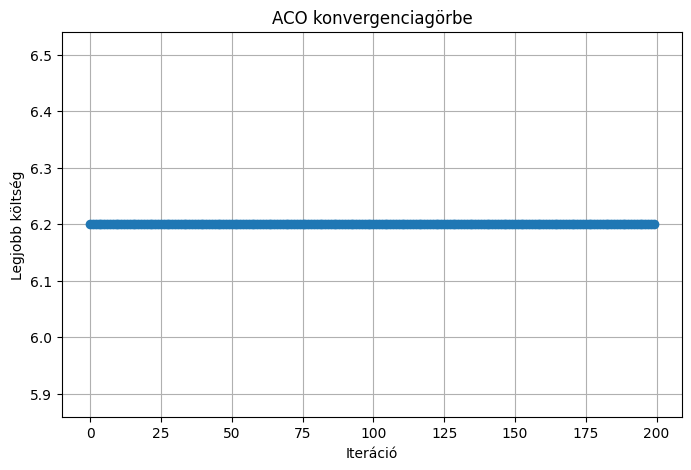

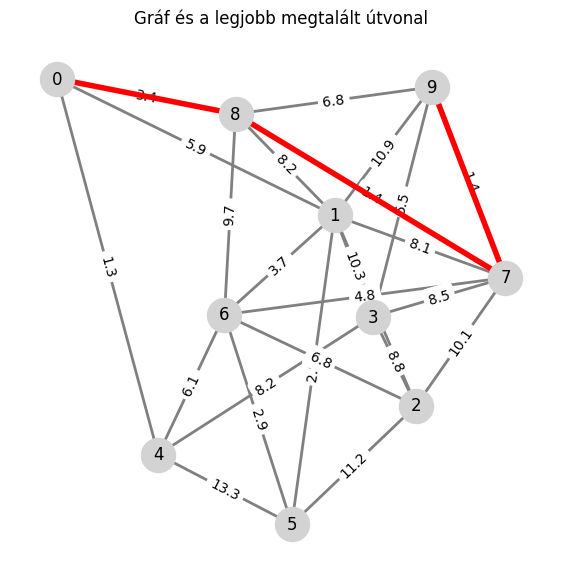

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_convergence(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history, marker="o")
    plt.xlabel("Iteráció")
    plt.ylabel("Legjobb költség")
    plt.title("ACO konvergenciagörbe")
    plt.grid(True)
    plt.show()

def plot_graph_and_path(graph, path):
    G = nx.Graph()

    for u in graph:
        for v, w in graph[u].items():
            G.add_edge(u, v, weight=w)

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(7, 7))

    nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightgray")
    nx.draw_networkx_edges(G, pos, width=2, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=12)

    edge_labels = {(u, v): graph[u][v] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    if path is not None:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            width=4,
            edge_color="red"
        )

    plt.title("Gráf és a legjobb megtalált útvonal")
    plt.axis("off")
    plt.show()

plot_convergence(history)
plot_graph_and_path(graph, best_path)

## 9. Rövid szöveges beszámoló

###Beállítások:

* A gráf csomópontjainak száma: 15
* A maximális él-súly: 15.0
* A kiinduló csomópont: 11
* A célcsomópont: 9
* Az ACO paraméterei:
  * n_ants: 50
  * n_iters: 200
  * alpha: 0.5
  * rho: 0.1
  * tau0: 0.1

###Eredmények:

* A talált legjobb útvonal: [11, 12, 9]
* Az útvonal költsége: 6.50
* A konvergenciagörbe viselkedése: A görbe gyakorlatilag már az első iteráció után „beállt” a legjobb költségre (6.50), és onnantól kezdve végig ugyanaz maradt. Ez azt mutatja, hogy az algoritmus nagyon gyorsan rátalált a számára legjobb útvonalra — vagy tényleg megtalálta az optimális megoldást, vagy egy olyan jó lokális optimumot, amiből később már nem tudott tovább javulni.


###Következtetések:

**Az eredmények értelmezése a gráf mérete és az ACO beállításai alapján:**
A használt gráf igazából nem túl nagy (15 csomópont), viszont a hangyák száma (50) és az iterációk száma (200) elég magasnak számít ehhez a problémához. Emiatt az ACO nagyon gyorsan és hatékonyan talált rá a legjobb útvonalra. Az, hogy a konvergencia ennyire gyors és stabil volt, azt jelzi, hogy ezzel a beállítással a feladat nem jelentett túl nagy kihívást az algoritmusnak — simán meg tudta oldani anélkül, hogy komolyabb keresésre lett volna szüksége.

## Térben ábrázolás:

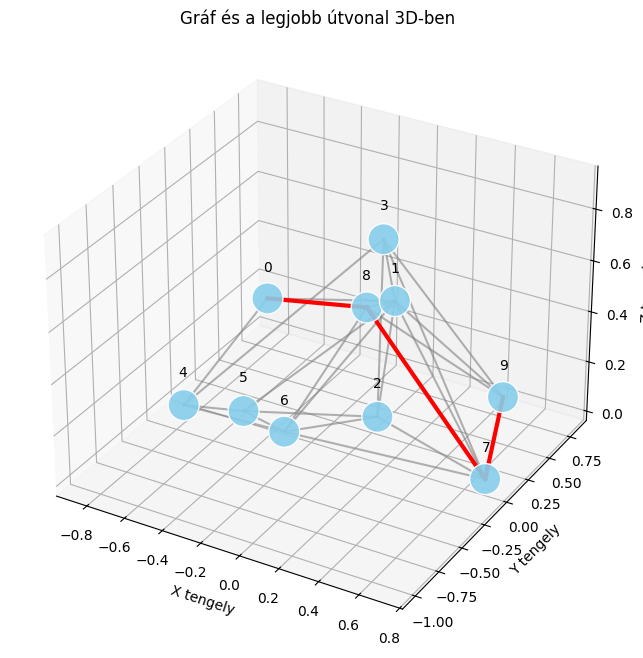

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

def plot_graph_3d(graph, path):
    G = nx.Graph()

    for u in graph:
        for v, w in graph[u].items():
            G.add_edge(u, v, weight=w)

    pos_2d = nx.spring_layout(G, seed=42) # 2D layout
    pos_3d = {node: (pos_2d[node][0], pos_2d[node][1], random.uniform(0, 1)) for node in G.nodes()} # Hozzáadunk egy random z koordinátát

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_nodes = [pos_3d[node][0] for node in G.nodes()]
    y_nodes = [pos_3d[node][1] for node in G.nodes()]
    z_nodes = [pos_3d[node][2] for node in G.nodes()]
    ax.scatter(x_nodes, y_nodes, z_nodes, s=500, c='skyblue', alpha=0.9, edgecolors='w')

    for edge in G.edges():
        x_edge = [pos_3d[edge[0]][0], pos_3d[edge[1]][0]]
        y_edge = [pos_3d[edge[0]][1], pos_3d[edge[1]][1]]
        z_edge = [pos_3d[edge[0]][2], pos_3d[edge[1]][2]]
        ax.plot(x_edge, y_edge, z_edge, c='gray', alpha=0.6)

    if path is not None:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        for u, v in path_edges:
            x_path_edge = [pos_3d[u][0], pos_3d[v][0]]
            y_path_edge = [pos_3d[u][1], pos_3d[v][1]]
            z_path_edge = [pos_3d[u][2], pos_3d[v][2]]
            ax.plot(x_path_edge, y_path_edge, z_path_edge, c='red', linewidth=3)

    for node, (x, y, z) in pos_3d.items():
        ax.text(x, y, z + 0.1, str(node), color='black', fontsize=10, ha='center', va='bottom')

    ax.set_title("Gráf és a legjobb útvonal 3D-ben")
    ax.set_xlabel("X tengely")
    ax.set_ylabel("Y tengely")
    ax.set_zlabel("Z tengely")
    plt.show()

plot_graph_3d(graph, best_path)


## Interaktív 3D ábrázolás (Plotly)

In [27]:
import plotly.graph_objects as go
import networkx as nx
import random

def plot_graph_3d_interactive(graph, path, start_node, goal_node):
    G = nx.Graph()

    for u in graph:
        for v, w in graph[u].items():
            G.add_edge(u, v, weight=w)

    pos_2d = nx.spring_layout(G, seed=42)
    pos_3d = {node: (pos_2d[node][0], pos_2d[node][1], random.uniform(0, 1)) for node in G.nodes()}

    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x = []
    node_y = []
    node_z = []
    node_text = []

    for node in G.nodes():
        x, y, z = pos_3d[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_text.append(f'Csomópont: {node}')

    node_trace = go.Scatter3d(
        x=node_x,
        y=node_y,
        z=node_z,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=0))
    )

    node_adjacencies = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
    node_trace.marker.color = node_adjacencies

    path_edge_x = []
    path_edge_y = []
    path_edge_z = []
    if path is not None and len(path) > 1:
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            x0, y0, z0 = pos_3d[u]
            x1, y1, z1 = pos_3d[v]
            path_edge_x.extend([x0, x1, None])
            path_edge_y.extend([y0, y1, None])
            path_edge_z.extend([z0, z1, None])

    path_trace = go.Scatter3d(
        x=path_edge_x,
        y=path_edge_y,
        z=path_edge_z,
        line=dict(width=5, color='red'),
        hoverinfo='none',
        mode='lines'
    )

    start_x, start_y, start_z = pos_3d[start_node]
    goal_x, goal_y, goal_z = pos_3d[goal_node]

    start_node_trace = go.Scatter3d(
        x=[start_x], y=[start_y], z=[start_z],
        mode='markers',
        marker=dict(size=12, color='green', symbol='square'),
        name='Start',
        hoverinfo='text',
        text=f'Kezdő csomópont: {start_node}'
    )

    goal_node_trace = go.Scatter3d(
        x=[goal_x], y=[goal_y], z=[goal_z],
        mode='markers',
        marker=dict(size=12, color='blue', symbol='diamond'),
        name='Cél',
        hoverinfo='text',
        text=f'Cél csomópont: {goal_node}'
    )

    fig = go.Figure(data=[edge_trace, node_trace, path_trace, start_node_trace, goal_node_trace],
                    layout=go.Layout(
                        title='Interaktív Gráf és Legjobb Útvonal 3D-ben',
                        showlegend=True,
                        hovermode='closest',
                        scene=dict(
                            xaxis=dict(showbackground=False, showticklabels=False, zeroline=False, title=''),
                            yaxis=dict(showbackground=False, showticklabels=False, zeroline=False, title=''),
                            zaxis=dict(showbackground=False, showticklabels=False, zeroline=False, title=''),
                        ),
                        margin=dict(b=20, l=5, r=5, t=40)
                    ))

    fig.show()

plot_graph_3d_interactive(graph, best_path, start_node, goal_node)
